**Este notebook muestra el proceso de limpieza de los frames antes de su procesado final. Se intentan eliminar los clústers que se detecten inválidos, es decir, aquellos que el DBSCAN detecta y no tienen sentido en la imagen de salida.**

1. Clustering sin limpiar
2. Clustering limpio
3. Bounding boxes con fondo negro
---

In [1]:
import pandas as pd
import pyvista as pv
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
def mostrar_archivo(nombre_csv: str):
    csv = pd.read_csv(nombre_csv)
    data_frame = pd.DataFrame(csv)

    X = data_frame['x']
    Y = data_frame['y']
    Z = data_frame['z']

    points = np.column_stack((Y, X, Z))  # combinación buena

    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    db = DBSCAN(eps=0.6, min_samples=20).fit(points_scaled)
    labels = db.labels_

    cloud = pv.PolyData(points)
    cloud.point_data['Cluster'] = labels

    plotter = pv.Plotter(window_size=[800, 500])
    plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=4, scalars='Cluster', show_scalar_bar=False)

    plotter.show_axes()
    plotter.camera.zoom(1.5)

    plotter.show()

## **MOSTRAR SIN FILTRAR**

c:\Users\aleja\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\aleja\anaconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


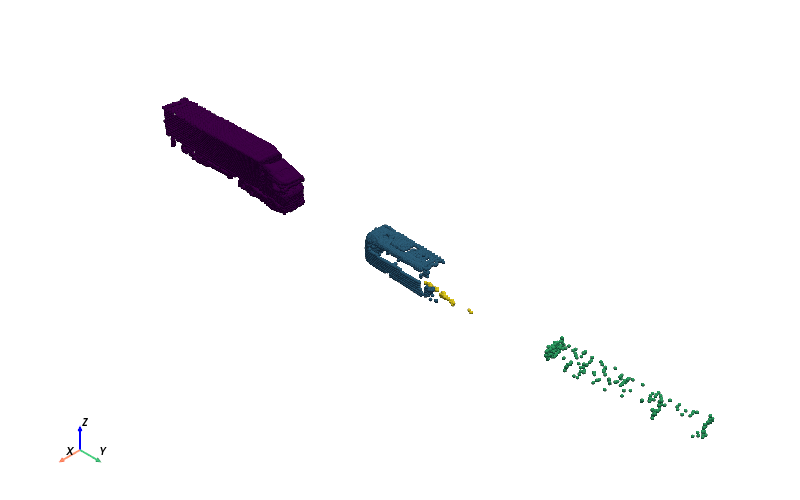

In [3]:
mostrar_archivo('pointcloud_1727346194_38163395.csv')

## **(LIMPIAR CLUSTERS "INVÁLIDOS")**

In [9]:
def limpiar_clusters_archivo(nombre_csv: str):
    csv = pd.read_csv(nombre_csv)
    data_frame = pd.DataFrame(csv)

    X = data_frame['x']
    Y = data_frame['y']
    Z = data_frame['z']

    points = np.column_stack((Y, X, Z))  # combinación buena
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    db = DBSCAN(eps=0.6, min_samples=20).fit(points_scaled)
    labels = db.labels_

    unique_labels = np.unique(labels[labels != -1])  # Excluir ruido

    min_puntos = 100
    cuenta_clust = {label: np.sum(labels == label) for label in unique_labels}

    for label, count in cuenta_clust.items():
        if count <= min_puntos:
            labels[labels == label] = -1

    """ahora, todos los puntos que sean '-1' se borren del dataframe
    después, guardarlo como CSV nuevo"""

    mask_valid_points = labels != -1
    data_frame_filtrado = data_frame[mask_valid_points] # type = 'pandas.core.frame.DataFrame'
    data_frame_filtrado.reset_index(drop=True, inplace=True)
    data_frame_filtrado.to_csv(f'limpio_{nombre_csv}', index=False)

In [10]:
limpiar_clusters_archivo('pointcloud_1727346194_38163395.csv')

## **MOSTRAR LIMPIO**

c:\Users\aleja\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\aleja\anaconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


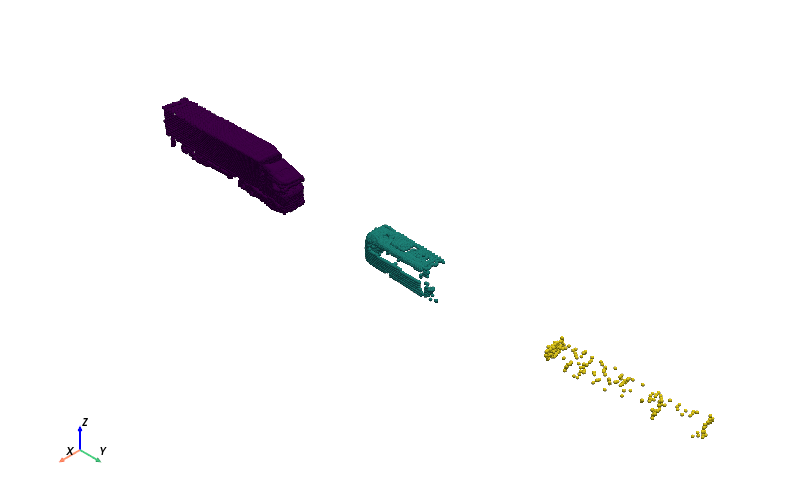

In [11]:
mostrar_archivo('limpio_pointcloud_1727346194_38163395.csv')

---

## **(BUCLE DE LIMPIEZA para todos los frames)**

In [43]:
# 4 min aprox
for archivo in os.listdir('pointclouds_filtro'):
    csv = pd.read_csv(f'pointclouds_filtro/{archivo}')
    data_frame = pd.DataFrame(csv)

    X = data_frame['x']
    Y = data_frame['y']
    Z = data_frame['z']

    points = np.column_stack((Y, X, Z))  # combinación buena 
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    db = DBSCAN(eps=0.6, min_samples=20).fit(points_scaled)
    labels = db.labels_

    unique_labels = np.unique(labels[labels != -1])  

    min_puntos = 100
    cuenta_clust = {label: np.sum(labels == label) for label in unique_labels}
    valid_labels = [label for label, count in cuenta_clust.items() if count >= min_puntos]

    for label, count in cuenta_clust.items():
        if count <= min_puntos:
            labels[labels == label] = -1

    mask_valid_points = labels != -1
    data_frame_filtrado = data_frame[mask_valid_points] # type = 'pandas.core.frame.DataFrame'
    data_frame_filtrado.reset_index(drop=True, inplace=True)
    data_frame_filtrado.to_csv(f'pointclouds_limpio/{archivo}', index=False)

---

## **IMAGEN CON FONDO NEGRO**

12218


c:\Users\aleja\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\aleja\anaconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


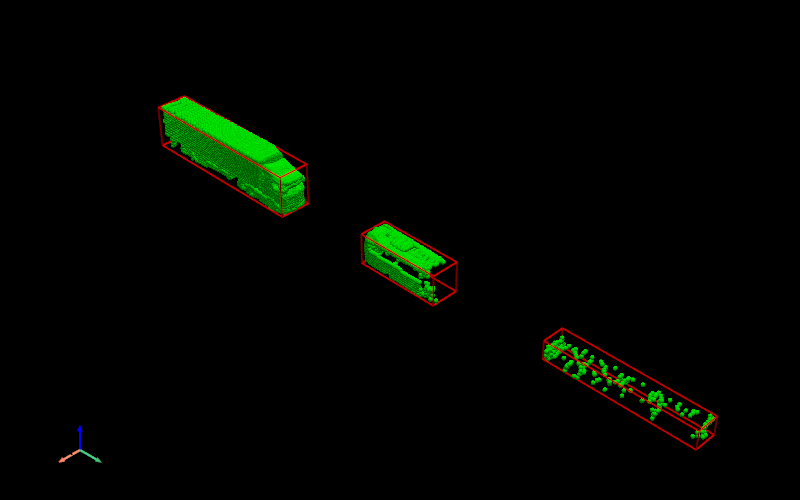

In [13]:
csv = pd.read_csv('limpio_pointcloud_1727346194_38163395.csv')
data_frame = pd.DataFrame(csv)

X = data_frame['x']
Y = data_frame['y']
Z = data_frame['z']

filtered_points = np.column_stack((Y, X, Z)) # combinación buena

scaler = StandardScaler()
filtered_points_scaled = scaler.fit_transform(filtered_points)

db2 = DBSCAN(eps=0.6, min_samples=20).fit(filtered_points_scaled)
clean_labels = db2.labels_

plotter = pv.Plotter(window_size=[800, 500])
plotter.set_background('black')
cloud = pv.PolyData(filtered_points)
plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=5, color='lime', show_scalar_bar=False)

bounding_boxes = []

for label in np.unique(clean_labels): 
    cluster_points = filtered_points[clean_labels == label]

    min_x, min_y, min_z = np.min(cluster_points, axis=0)
    max_x, max_y, max_z = np.max(cluster_points, axis=0)
    
    bounding_boxes.append((min_x, max_x, min_y, max_y, min_z, max_z))

for bbox in bounding_boxes:
    box = pv.Cube(bounds=bbox)
    plotter.add_mesh(box, color='red', style='wireframe', line_width=1.5)

plotter.show_axes()
plotter.camera.zoom(1.5)

plotter.show()